# **Heart Disease Classification With a K-Nearest Neighbors Algorithm**
**Authors:** Andy Hu, Sharon Tu, Dylan Zhang, Renz Tingson

# 1) Introduction
When will we find the cure to cancer? What is the newest cutting edge medical technology? Medicine is on the forefront of innovation and advancement, with people pouring in extensive resources for research purposes and progression. In particular, heart disease is the second leading cause of death among Canadians, with roughly 1 in 12 adults recieving a diagnosis within their lifetime. Heart disease is a broad term that encompasses a variety of conditions affecting the cardiovasular system, comprised of the heart and blood vessels. The most common of these conditions include coronary heart disease, angina, heart attacks, heart failure, arrhythmias, and stroke. As such, it is crucial to be able to detect and diagnose heart disease early in order to prevent long-term deficits, or potentially even death. Our research aims to find ways in which we can accomplish this in way that is accessible to everyone.

## Research Question
How well can we classify if a patient has a heart disease based on factors that can be more easily monitored at home, such as their age and maximum heart rate achieved? For our purposes, presence of a heart disease is indicated by greater than 50% diameter narrowing of blood vessels. 

## Dataset
We will be using the Cleveland dataset for our research, which contains 14 distinct characteristics about each patient in the data. We will be focusing primarily on numerical predictors rather than categorical labels, with our classification predicting a patient's condition of having a heart disease. The Cleveland dataset classifies patient's heart disease on a scale from zero to four, where zero means that there is no presence of a heart disease, whereas the labels one to four indicate the severity of the heart disease in increasing order. For our purposes, we will treat the labels from one to four all as one, indicating the presence of a heart disease.

# 2) Methods & Results
To begin our research, we first explore the dataset to discover what easily monitorable factors constitute the most significant impact in determining whether someone has a heart disease or not. After finding these predictor variables, we employ a K-Nearest Neighbors classification model utilizing the Cleveland dataset.

In [1]:
# Load in all preliminary packages needed for analysis
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
## Make a vector of column names to use for the dataset
vec_names <- c( "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num" )

# Load the dataset into R, and clean/wrangle the data into a tidy format
heart_data <- read_csv("data/cleveland_heart.txt", col_names = vec_names) |>
    mutate(across(sex:cp, as_factor)) |>                                  # Turn all categorical values into factors since they are
    mutate(across(fbs:restecg, as_factor)) |>                             # defaulted as chars when loaded
    mutate(exang = as_factor(exang)) |>
    mutate(across(slope:num, as_factor)) |>
    mutate(num = replace(num, num == 2 | num == 3 | num == 4, 1))         # This column labels patients on a scale of 0 to 4, where 0 is heart disease,
                                                                          # and 1-4 describe the severity of the heart disease. We turn these severity
                                                                          # cases into a value of 1, indicating presence of heart disease.
head(heart_data)
# write_csv(heart_data, "data/cleveland_data.csv")         # writes a tidy version of the original text file into the working directory for future reference

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


### Exploratory Analysis
We first use the entire dataset to gain meaningful insights from it. Let us first understand the column parameters a bit better through a table describing their labels.

In [3]:
data_labels <- tibble(label = c("age", "sex", "cp", "trestbps", "chol",
                                "fbs", "restecg", "thalach", "exang", "oldpeak",
                                "slope", "ca", "thal", "num"), 
                      description = c("age in years", "male(1) or female(0)",
                                      "Chest Pain Type (4 categories)",
                                      "Resting Blood Pressure (mmHg)",
                                      "Serum Cholesterol (mg/dl)",
                                      "Fasting Blood Sugar > 120mg/dl (true or false)\n",
                                      "Resting electrocardiographic results \n (0 as normal, else abnormality)",
                                      "Maximum Heart Rate Achieved (bpm)",
                                      "Exercise-induced angina (true or false)",
                                      "ST depression from exercise",
                                      "Slope of Peak Exercise ST Segment",
                                      "Number of Major Vessels (0-3)",
                                      "State of Heart Illness",
                                      "Condition (true or false)"))

data_labels

label,description
<chr>,<chr>
age,age in years
sex,male(1) or female(0)
cp,Chest Pain Type (4 categories)
trestbps,Resting Blood Pressure (mmHg)
chol,Serum Cholesterol (mg/dl)
fbs,Fasting Blood Sugar > 120mg/dl (true or false)
restecg,"Resting electrocardiographic results (0 as normal, else abnormality)"
thalach,Maximum Heart Rate Achieved (bpm)
exang,Exercise-induced angina (true or false)


Our research aims to identify predictors that can be easily tracked at home without the need to go to a hospital to specifically test for heart disease, so that individuals can be proactive about their health and wellbeing at all times and have the ability to discover the potential presence of a heart disease based on easily monitorable predictors. As such, we specifically pick out predictors that everyone can monitor: Age, Sex, Serum Cholesterol, Resting Blood Pressure, Fasting Blood Sugar Level, Maximum Heart Rate Achieved, and Exercise-induced angina. 

In [4]:
heart_filtered <- heart_data |>
    select(age, sex, chol, trestbps, fbs, thalach, exang)

head(heart_filtered)

age,sex,chol,trestbps,fbs,thalach,exang
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
63,1,233,145,1,150,0
67,1,286,160,0,108,1
67,1,229,120,0,129,1
37,1,250,130,0,187,0
41,0,204,130,0,172,0
56,1,236,120,0,178,0


We decide that for our research, we will only be considering the numerical labels for analysis to determine relationships between predictor variables through simple visualizations of scatter plots and finding correlations between our variables. Numerical columns include age, resting blood pressure, cholesterol levels, and maximum heart rate. 

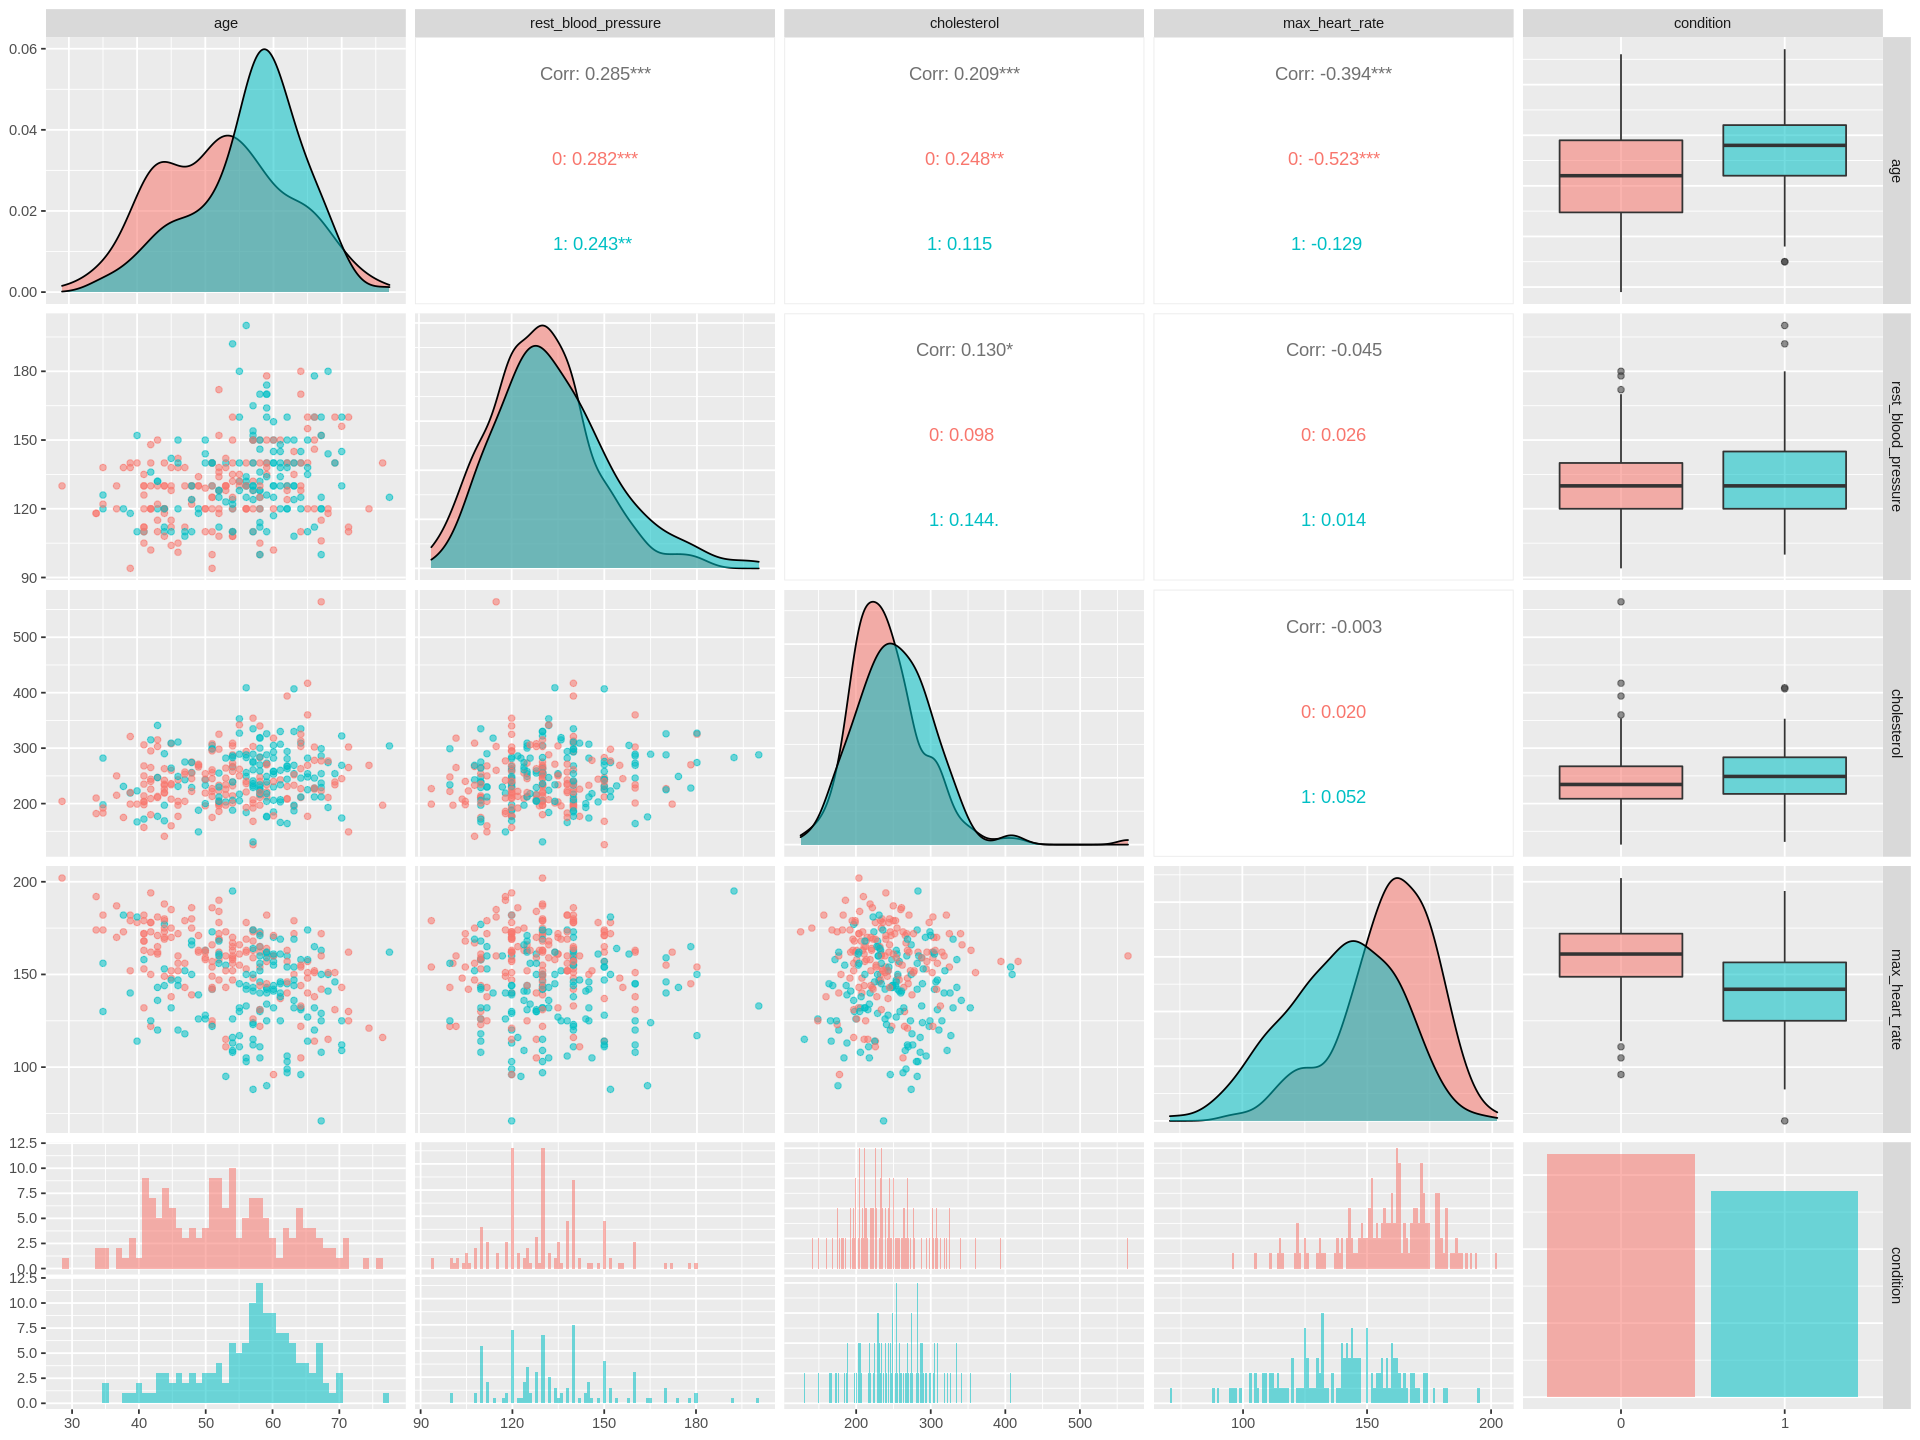

In [5]:
options(repr.plot.width = 16, repr.plot.height = 12)

# Select only numerical columns as well as response variable of num, indicating the condition of the patient (has heart disease or not)
heart_filtered <- heart_data |>
    select(age, trestbps, chol, thalach, num)

# Create more interpretable column names
colnames(heart_filtered) <- c("age", "rest_blood_pressure", "cholesterol", "max_heart_rate", "condition")

# Plot simple visualization to explore dataset
distribution_plot <- ggpairs(data = heart_filtered,
                            aes(colour = condition, alpha = 0.6),
                            lower=list(combo=wrap("facethist",binwidth=1)))
distribution_plot

Based on the given plot above, we can easily explore the dataset from a bird's eye view. We quickly notice that the dataset contains more patients without heart disease compared to with heart disease. We also notice that some predictors combined together have little accuracy in determining whether a patient has heart disease or not, such as the scatter plot resulting from maximum heart rate and cholesterol levels, or resting heart rate and maximum heart rate together. We take note of the different Pearson correlations shared by certain factors, which classifies the strength and direction of the relationship between both variables. We quickly notice that the highest Pearson correlation given the data occurs while plotting maximum heart rate and age together, and that they have a negative relationship. We also see that compared to the other scatter plots, the distinction between those with heart disease and without is most prominent in this plot, indicating the potential for a relatively high accuracy model that can be trained from using those two predictors. 

As a matter of fact, age and maximum heart rate have a natural relationship with one another. According to the Centers for Disease Control and Prevention, an individual's maximum heart rate should be 220 subtracted by your age, showing a strong correlation extractable from age and maximum heart rate. Furthermore, age itself plays a massive role in overall health of the heart and therefore plays a significant role in predicting heart disease. With aging, the heart's ability to pump blood to the rest of the body worsens, as a result of simply overworking and the buildup of fat deposits and increased stiffness. 

As such, we will choose to use age and maximum heart rate achieved for the rest of this paper.

In [6]:
# Compress the data so that it only contains the predictors we care about (age, maximum heart rate) and response variable of condition
heart <- heart_filtered |>
    select(age, max_heart_rate, condition)
head(heart)

age,max_heart_rate,condition
<dbl>,<dbl>,<fct>
63,150,0
67,108,1
67,129,1
37,187,0
41,172,0
56,178,0


Through the use of simple tables and calculations, we can understand the relationship between our chosen predictors better and overall dataset to look for any outliers or imbalances present within the dataset.

In [7]:
# Calculate the number of NA values present
na <- sum(is.na(heart))
na

[1] 0

With a simple calculation, we discover that there are no NA values in our dataset, so it is unnecessary to worry about them nor remove any. 

In [8]:
# Count number of those with and without heart disease
num_obs <- heart |>
    group_by(condition) |>
    summarize(count = n())
num_obs

condition,count
<fct>,<int>
0,164
1,139


From above, a condition of 0 indicates no heart disease, while a value of 1 indicates the presence of a heart disease. The data is relatively balanced between patients with and without heart disease, although there is a slight bias towards those without heart disease. Up sampling of those with heart disease could be possible, but not necessary.

In [9]:
means <- heart |>
    group_by(condition) |>
    summarize(across(age:max_heart_rate, mean))
means

condition,age,max_heart_rate
<fct>,<dbl>,<dbl>
0,52.58537,158.378
1,56.62590,139.259


Based on the table and the graphs above, we can see that those with higher age and lower maximum heart rate tend to have a heart disease, while those with lower age and higher maximum heart rate tend to not have heart disease. From the data, we see that the mean average for age was around 57 for those with heart disease compared to 53 to those without heart disease, and that the maximum heart rate for those with heart disease was around 140bpm, and around 158 for those without. Let us zoom in on the graph corresponding to the relationship between age and maximum heart rate now. 

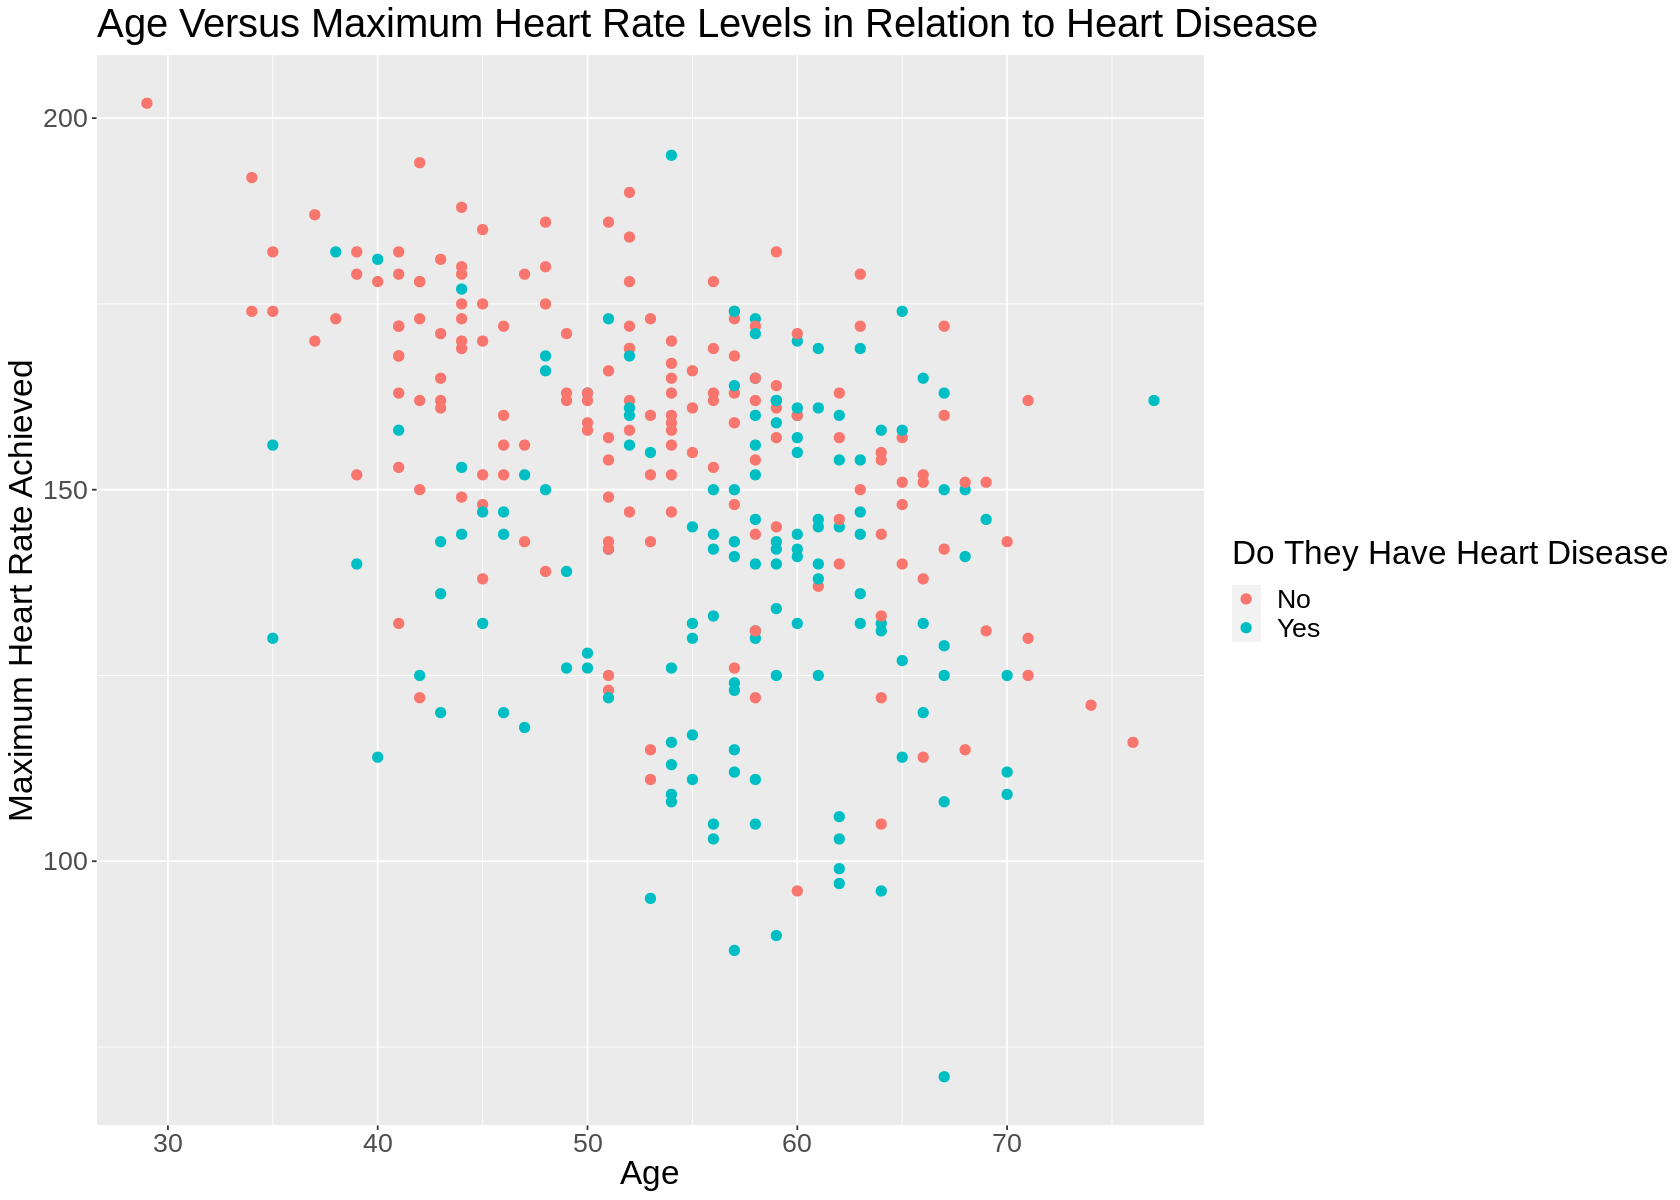

In [10]:
options(repr.plot.width = 14, repr.plot.height = 10)

heart_scatter <- heart |>
    ggplot(aes(x = age, y = max_heart_rate, color = condition)) +
    geom_point(size = 2.5) +
    xlab("Age") +
    ylab("Maximum Heart Rate Achieved") +
    labs(color = "Do They Have Heart Disease") +
    ggtitle("Age Versus Maximum Heart Rate Levels in Relation to Heart Disease") +
    scale_color_discrete(labels = c("No", "Yes")) +
    theme(text = element_text(size = 20))
heart_scatter


Just like our table above showed, those with higher age and lower maximum heart rate achieved seem to have a higher likelihood of having a heart disease compared to those with lower age and higher maximum heart rate achieved, and we also take note of the negative relationship between both variables.

### Model Optimization

Now that we have explored the dataset thoroughly, chosen the predictor variables of age and maximum heart rate, and analyzed the relationship between these variables, we are ready to build our model to predict whether or not a patient has a heart disease based on these factors. First, we set the seed to ensure that our data is reproducible, and split our data into a training and testing set, while ensuring that the data is shuffled and stratified for the condition label. We perform such steps because we would like to train our model on the training set, and then test its accuracy on the testing set. This is done so that we can judge the accuracy of our model as it makes new predictions on data it has never seen before, so as to not overestimate its accuracy. Imagine overestimating a model's accuracy for determining if a patient has something as extreme as a heart disease!

In [11]:
set.seed(1500)

# Splits our entire dataset into 75% training, and 25% testing
heart_split <- initial_split(heart, prop = 0.75, strata = condition)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

After splitting our data into 75% training and 25% testing, we are now ready to create our model. First, we create a recipe for data preprocessing, where we center the data by subtracting each observation from the mean of that observation, and scale it by dividing by its standard deviation. This ensures that in our K-Nearest Neighbors algorithm, it uses the actual straight line distance between each point without bias towards different scalings of the $x$ and $y$ axes. Following, we create our actual model specification to use for the algorithm, specifying the K-Nearest Neighbors algorithm for classification, where we are aiming to tune a value of `k` to use as the number of neighbors. To determine this value of `k`, we make a table of potential `k` values to test, and use 5-fold cross validation to essentially create 5 different models and test these values of `k` for each model to compute meaningful accuracy measurements. We ensure to set the stratification of these folds to the condition of the patient, to ensure that each fold has an equal amount of data for both conditions. Of course, we can't use the testing data here since it would expose our model to data we are using to test its accuracy on, so we opt to 5-fold cross validation which only utilizes the training data. We collect the results of these five different models after fitting each one to its respective fold from the cross validation and filter for the accuracy measures that the models averaged out to have on the different values of `k` tested for. This allows us to track the accuracy of our model so far on just the training data, and choose a value of `k` number of neighbors that optimizes our K-Nearest Neigbors algorithm.

In [12]:
## Recipe
set.seed(1500)

# - Make a recipe with a formula predicting condition based on the predictors of
#   age and maximum heart rate achieved, using training data.
# - Standardize the data to ensure the scales are properly set for use 
#   of straight line distance in the K-nearest neighbors algorithm
heart_recipe <- recipe(condition ~ ., data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Create the model specification using Euclidean straight line distance
# and tune the number of neighbors
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# create the folds for 5-fold cross-validation
heart_vfold <- vfold_cv(heart_training, v = 5, strata = condition) 

# create a table of neighbor values to test (tuning the k value)
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

# compute statistics at different k values
heart_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    tune_grid(resamples = heart_vfold, grid = gridvals) |>
    collect_metrics()

# discover the accuracy of the model at different values of k
accuracies <- heart_results |>
    filter(.metric == "accuracy")
accuracies

! Fold1: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5944181,5,0.02761267,Preprocessor1_Model01
6,accuracy,multiclass,0.6518138,5,0.02819976,Preprocessor1_Model02
11,accuracy,multiclass,0.6828415,5,0.02429520,Preprocessor1_Model03
16,accuracy,multiclass,0.6780018,5,0.03072141,Preprocessor1_Model04
21,accuracy,multiclass,0.6779051,5,0.03792100,Preprocessor1_Model05
26,accuracy,multiclass,0.6780018,5,0.03072141,Preprocessor1_Model06
31,accuracy,multiclass,0.6867896,5,0.03062973,Preprocessor1_Model07
36,accuracy,multiclass,0.6867852,5,0.03089944,Preprocessor1_Model08
41,accuracy,multiclass,0.6867896,5,0.02366662,Preprocessor1_Model09


Given the accuracies, we plot the accuracies at different values of `k`, so that we can visualize the optimal `k` value to use.

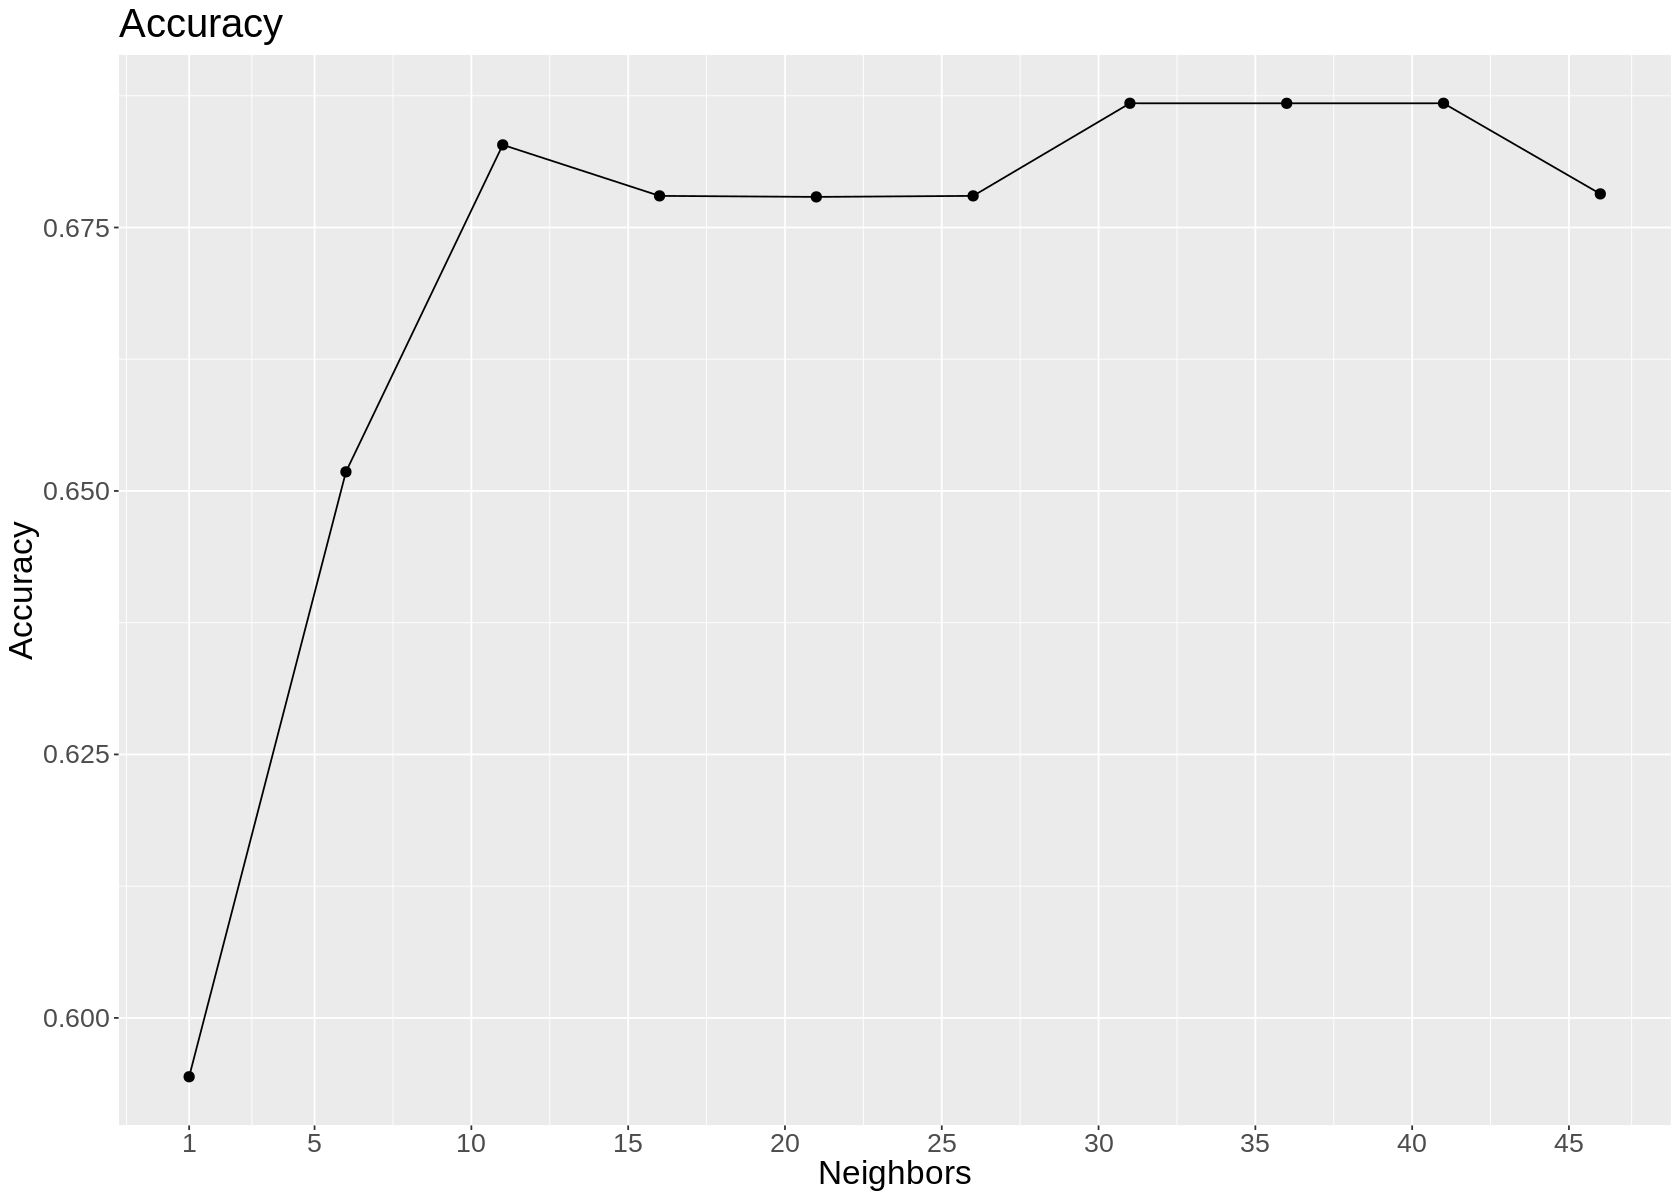

In [13]:
options(repr.plot.width = 14, repr.plot.height = 10)

# plot of the accuracies at different values of k
accuracy_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point(size = 2.5) +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy", title = "Accuracy") + 
    scale_x_continuous(breaks = c(1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50)) +
    theme(text = element_text(size = 20))

accuracy_plot

The graph above represents the accuracy of the model at different `k` values, or number of neighbors. We see that the graph reaches a its first peak at around 10 neighbors, and then fluctuates about that point for a while. Based on this, we can choose a `k` value of 15 since it seems like increasing the neighbors from that point on does not make a significant difference in the accuracy of the model, and these accuracies themselves are estimates in the first place, so choosing any value of `k` to be around that area is not significantly different. We also know that as the number of neighbors increases to an absurd amount, such as 100, the accuracy would decrease due to underfitting to the extreme, where the model would be unable to capture the trends in the data and therefore carry an overall 'smooth' touch to it. We choose the value of `k` to be a bit above the first peak at 10 to avoid the possibility of overfitting, which occurs when the model captures too much noise in the dataset. 

Using our chosen value of `k` as 15, we are now ready to make a new model based on this best value. Keep in mind that all of the previous steps were only done to find an optimal value of `k` to use for the model. To begin, we make a new model specification using only the value of `k` extracted from the previous findings, and fit this model to the entire training set. Using this model, we pass in the testing set from the very beginning so that it can predict the condition of patients on data that the model has never seen before.

In [14]:
# Using our analyzed best k value of 8 to retrain the model
heart_optimized <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_optimized) |>
    fit(heart_training) 

# use our retrained model with the best k value to predict values on the training set
predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)

# get the statistics of our model's accuracy
results <- predictions |>
    metrics(truth = condition, estimate = .pred_class) |>
    filter(.metric == "accuracy")

results

# visualize the model predictions in a matrix
predictions |>
    conf_mat(truth = condition, estimate = .pred_class)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7631579


          Truth
Prediction  0  1  2  3  4
         0 33 10  0  0  0
         1  8 25  0  0  0
         2  0  0  0  0  0
         3  0  0  0  0  0
         4  0  0  0  0  0

We see that our model had an approximate 76% accuracy while predicting the condition of patient on our testing data set. As such, we would not be confident employing this model as a sole predictor for others to use in order to determine whether or not they have heart disease. We see that the model made 58 correct predictions, which can be calculated by summing the amount of true positive (1 and 1) and true negative (0 and 0). Meanwhile, it had 8 counts of false positive, and 10 counts of false negative. In this case, a false negative is a horrible outcome, because this means that our model incorrectly predicted 10 people to be absent of heart disease, when in reality they have it. Doing some further calculations, we can see that the false positives account for 13% of the predictions, which can be considered fairly high for diagnosis of a terminal disease like heart disease.

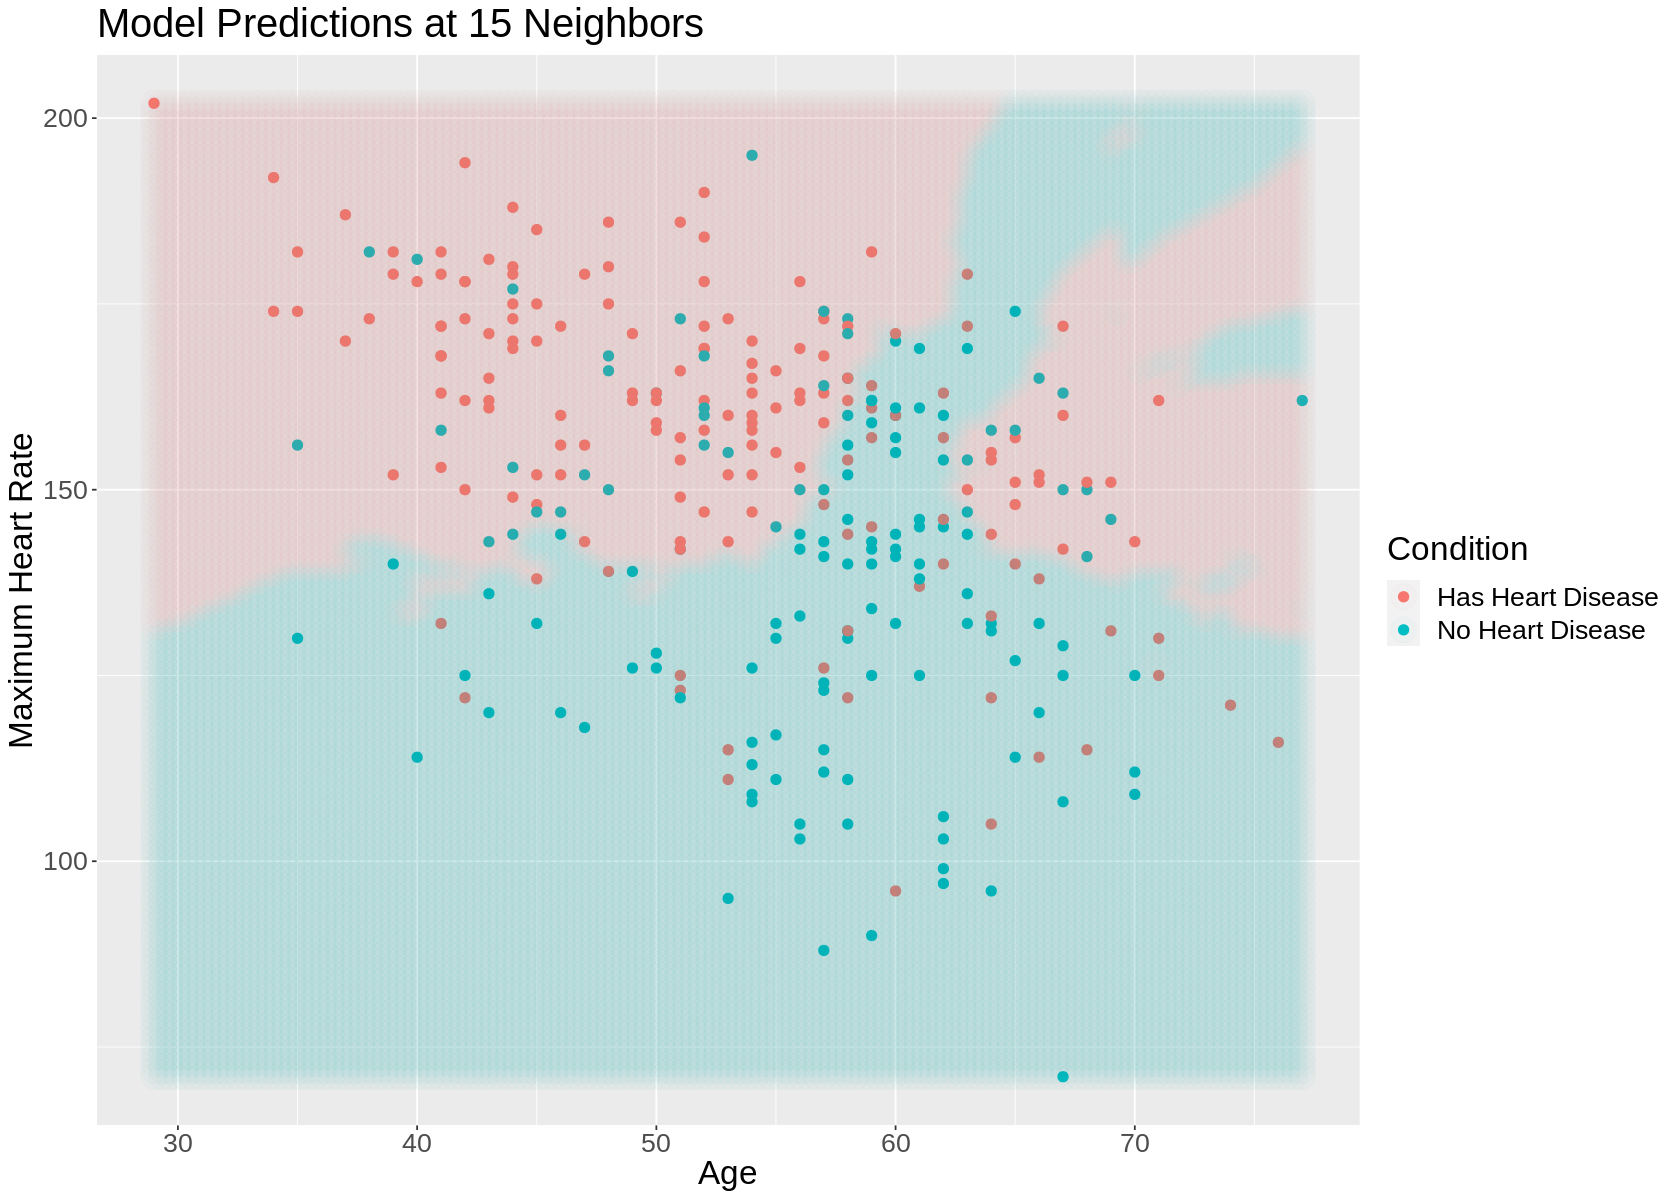

In [15]:
options(repr.plot.width = 14, repr.plot.height = 10)

# create the grid of area/smoothness vals, and arrange in a data frame
age_grid <- seq(min(heart$age), 
                max(heart$age), 
                length.out = 150)
hr_grid <- seq(min(heart$max_heart_rate), 
                max(heart$max_heart_rate), 
                length.out = 150)
asgrid <- as_tibble(expand.grid(age = age_grid, 
                                max_heart_rate = hr_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(condition = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = heart, 
             mapping = aes(x = age, 
                           y = max_heart_rate, 
                           color = condition), 
             size = 2.5) +
  geom_point(data = prediction_table, 
             mapping = aes(x = age, 
                           y = max_heart_rate, 
                           color = condition), 
             alpha = 0.02, 
             size = 7) +
  labs(color = "Condition", 
       x = "Age", 
       y = "Maximum Heart Rate",
       title = "Model Predictions at 15 Neighbors") +
  scale_color_discrete(labels = c("Has Heart Disease", "No Heart Disease")) +
  theme(text = element_text(size = 20))

wkflw_plot


From the graph shown above, we visualize the regions of area that our model would predict for a patient having or not having a heart disease. With our chosen value of 15 nearest neighbors, we see that the graph is pretty well fit, with a slight favour towards an overfit, as indicated by the presence of 'peninsulas' and jagged edges between the borders of either classification. 

# 3) Discussion

## Summary
<!-- summarize what you found. discuss whether this is what you expected to find? -->
Through our research in determining how well we can classify if a patient has a heart disease based on factors that can be more easily monitored at home, we discovered that age and maximum heart rate had a high correlation with one another compared to other variables, and had a negative relationship. Using these two predictors to classify patients based on their heart disease condition, we discover that on average, those with higher age and lower maximum heart rate are more at risk of heart disease. Meanwhile, those with a lower age and higher maximum heart rate are less likely to have a heart disease. These findings align with what we expected. Specifically, we expected that those at a higher age are more likely to have a heart disease because the heart muscle has been worked for much longer, leading to inefficiencies and buildup of unwanted waste. As such, the heart would be less effective, leading to heart disease. On the other hand, a lower maximum heart rate should correspond to a higher chance of having a heart disease because this means that the patient's heart cannot beat fast enough and pump as much blood to other parts of the body compared to those with a higher maximum heart rate, indicating that the heart may be strained or less effective; this corresponds to a higher chance of heart disease as well. After training our model on the best value of `k`, we find that it has a roughly 76% accuracy, and so we would not be confident employing this model as a primary method of deteriminig whether or not someone has a heart disease, and should rather be used as a supplement to existing tests. Such tests could require the need to visit doctors periodically to more thoroughly check a patient's health and as a consequence, their risk of heart disease. 

## Significance
Our research aimed to classify a patient using factors that are extremely easily monitorable to classify if they have a heart disease or not, and such findings could have a great impact in reducing the amount of fatal heart disease problems. If someone can easily use our model to reliably predict if they are at risk of heart disease, they may take heed and seek further medical attention from a specialist or doctor before it gets out of hand and terminal. The predictors we use are all easily monitorable factors that do not require much external equipment to measure, so it is readily accessible by everyone to self diagnose. Maximum heart rate can be monitored through fitness watches and most fitness machines. However, our model only has an approximate 76% accuracy, and thus would not be entirely reliable to use as a sole indicator, and should be combined with other methods. This raises a few questions below.


## Future Questions
While finding a model to predict whether or not someone has a heart disease is great, there are still many restrictions and limitations involved with our research, which raises the awareness to further questions. For example, can our model become a mainsteram way for people to reliably test if they have a heart disease and seek more medical attention? Also, to ensure maximum accuracy of our model, we may consider adding other predictors that have a larger impact on the effects on heart disease, and potentially revise our current model to support these additions and possibly remove some less significant predictors. Of course, we would like to maintain the aspect of the predictor being easily monitorable by anyone without the need to reach out to a sspecialist. We also recognize the limitations of employing a KNN algorithm for classification, so other variations could be considered. 

# 4) References
- https://archive.ics.uci.edu/dataset/45/heart+disease
- https://medlineplus.gov/ency/article/004006.htm
- https://www.nia.nih.gov/health/heart-health-and-aging
